# 02_plot_headmotion_figure

In [1]:
import numpy as np
from os.path import join as pjoin
from os.path import isdir
import os
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import mne
from mne_bids import write_raw_bids, BIDSPath
from scipy import stats
import re
from scipy import signal
import pandas as pd
from scipy import signal, fftpack
from PIL import Image

In [80]:
# define variables
sub_list = ['{0:0>2d}'.format(sub) for sub in np.arange(1,12)]
run_list = ['{0:0>2d}'.format(run) for run in np.arange(1,9)]

# set path
bids_root = '/nfs/e5/studyforrest/forrest_movie_meg/gump_meg_bids'
results_pth = '/nfs/e5/studyforrest/forrest_movie_meg/tech_val_results'
fig_pth = '/nfs/e5/studyforrest/forrest_movie_meg/tech_val_results/head_motion_figure'
if os.path.exists(fig_pth) is False:
    os.mkdir(fig_pth)

# set fiducials channel
coord = {'nas' : ['HLC0011','HLC0012','HLC0013'], 
         'lpa' : ['HLC0021','HLC0022','HLC0023'], 
         'rpa' : ['HLC0031','HLC0032','HLC0033']}

In [122]:
def mv2bin(mv, head_motion_bins):
    
    for i in np.arange(head_motion_bins.size):
        if head_motion_bins[i] <= mv <= head_motion_bins[i+1]:
            return i

def bins2mv_arr(head_bin, max_mv_bin, head_motion_bins):
    
    head_mv = np.array([])
    for i in np.arange(max_mv_bin+1):
        tmp_mv = np.ones((1, head_bin[i]))*((head_motion_bins[i]+head_motion_bins[i+1])/2)
        head_mv = np.append(head_mv,tmp_mv)
    
    return head_mv

def plot_sub_hmv_hist(sub_motion_bins, head_motion_bins, fig_info, cumulative=False, save_pth=None, show=False):
    """
    use hpi data to plot histgram of head movement
    
    Parameters
    ----------
        sub_motion_bins: head_motion[sub][run]
        fig_info: [sub_idx, run_idx]
        save_pth: str
    """
    
    coord = ['nasion', 'lpa', 'rpa']
    color = ['lightskyblue', 'pink', 'lightgreen']

    fig, axes = plt.subplots(1,3,figsize=(16, 5))
    fig.suptitle('Head Movement')
    for j in np.arange(3):
        mv = bins2mv_arr(sub_motion_bins[0][j,:], mv2bin(sub_motion_bins[1][j], head_motion_bins), head_motion_bins)
        x, bins, p = axes[j].hist(mv, alpha=0.4, density=True, bins=1000, label=coord[j], color=color[j])
        height = []
        for item in p:
            height.append(item.get_height()/sum(x))
            item.set_height(item.get_height()/sum(x))
        if cumulative:
            ax2 = axes[j].twinx()
            ax2.hist(mv, density=True, bins=1000, label=f'{coord[j]} CDF', histtype='step', cumulative=cumulative, color=color[j])
            ax2.set_ylabel('CDF')
            plt.subplots_adjust(left=0.05, right=0.95, wspace=0.4)
        axes[j].set_ylim(top=0.008)
        axes[j].legend(loc=0)
        axes[j].set_xlabel('mm')
        axes[j].set_ylabel('normalized histgram')
        
    if save_pth is not None:
        plt.savefig(pjoin(save_pth, f'sub-{fig_info[0]}_run-{fig_info[1]}_head_motion.jpeg'),dpi=600)
    if show is False:
        plt.close()


In [4]:
# load data
head_motion = pd.read_pickle(pjoin(results_pth, 'head_motion.pickle'))
head_motion_bins = np.load(pjoin(results_pth, 'head_motion_bins.npy'))

In [7]:
# plot head movement for each sub and each run
tmp_fig_save_pth = pjoin(fig_pth, 'tmp')
if os.path.exists(tmp_fig_save_pth) is False:
    os.mkdir(tmp_fig_save_pth)

for sub in sub_list:
    if sub == '01':
        run_ls = run_list + ['09']
    else:
        run_ls = run_list 
    for run in run_ls:
        plot_sub_hmv_hist(head_motion[sub][run], head_motion_bins, [sub, run], save_pth=tmp_fig_save_pth)

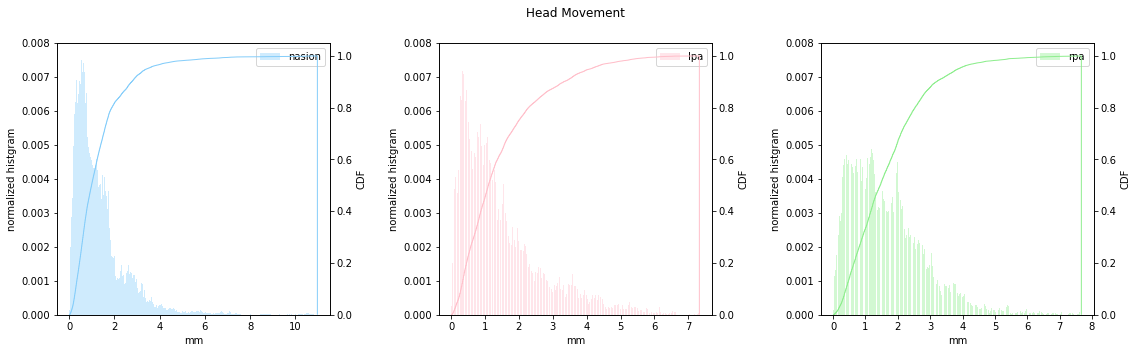

In [124]:
# plot head movement for all data
all_head_motion = np.zeros(head_motion['01']['01'][0].shape)
for sub in sub_list:
    if sub == '01':
        run_ls = run_list + ['09']
    else:
        run_ls = run_list 
    for run in run_ls:
        all_head_motion += head_motion[sub][run][0]

plot_sub_hmv_hist((all_head_motion.astype(int), np.ones(3)*np.max(head_motion_bins)), head_motion_bins, ['all', 'all'], save_pth=fig_pth, cumulative=True, show=True)


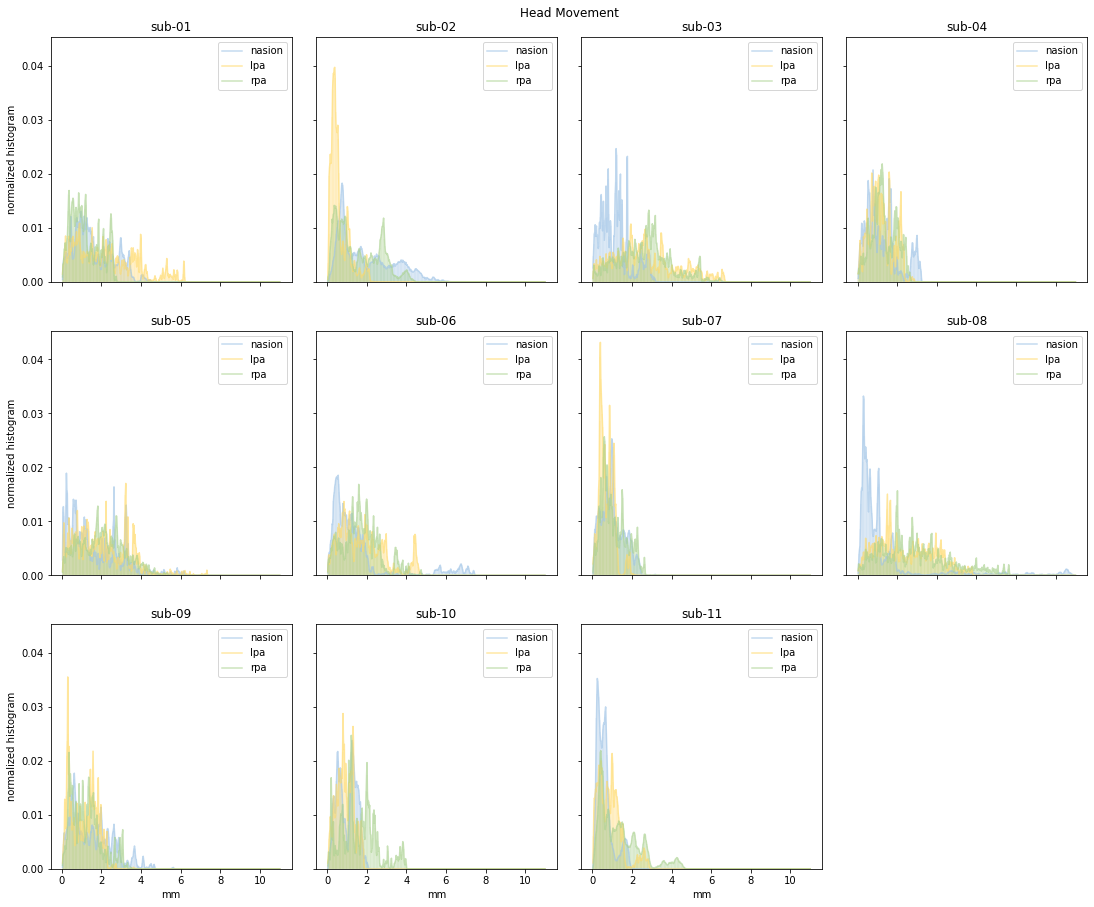

In [134]:
# Supplymentary figure 1
fig, axes = plt.subplots(3, 4, figsize=(16,14), sharex=True, sharey=True)
fig.suptitle('Head Movement')
plt.subplots_adjust(top=0.95, left=0.05, right=0.95, wspace=0.1)

for i, sub in enumerate(sub_list):
    sub_head_motion = np.zeros(head_motion['01']['01'][0].shape)
    sub_max = np.zeros((3,1))
    
    if sub == '01':
        run_ls = run_list + ['09']
    else:
        run_ls = run_list 
        
    for run in run_ls:
        sub_head_motion += head_motion[sub][run][0]
        sub_max = np.concatenate((sub_max, head_motion[sub][run][1].reshape((3,1))), axis=1)
     
    sub_max = np.max(sub_max, axis=1)
    sub_head_motion_bins = (sub_head_motion.astype(int), sub_max)
    
    motion_bins = head_motion_bins[1::2]
    ax = axes[i//4][i%4]
    for j in np.arange(3):
        coord = ['nasion', 'lpa', 'rpa']
        color = [(157/255, 195/255, 230/255), (255/255, 217/255, 102/255), (169/255, 209/255, 142/255)]
        tmp = sub_head_motion_bins[0][j,:]/np.sum(sub_head_motion_bins[0][j,:])
        tmp = tmp[:-1:2] + tmp[1::2]
        ax.bar(motion_bins[1:], tmp, width=0.1, color=color[j], alpha=0.1)
        ax.plot(motion_bins[1:], tmp, color=color[j], label=coord[j], alpha=0.6)
    ax.legend(loc=0)
    ax.set_title(f'sub-{sub}')
    if i//4 == 2:
        ax.set_xlabel('mm')
    if i%4 == 0:
        ax.set_ylabel('normalized histogram')
    
axes[2][3].set_visible(False)
fig.savefig(pjoin(fig_pth, 'overlap_sub_headmotion.jpg'))

In [29]:
cdf = np.cumsum(all_head_motion, axis=1)
for i in np.arange(3):
    cdf[i, :] = cdf[i, :]/cdf[i, -1]

for i in np.arange(3):
    coord = ['nasion', 'lpa', 'rpa']
    print(f'{coord[i]} 50% is {np.interp(0.5, cdf[i,:], head_motion_bins[1:])} mm')
    print(f'{coord[i]} 90% is {np.interp(0.9, cdf[i,:], head_motion_bins[1:])} mm')
    print(f'{coord[i]} 95% is {np.interp(0.95, cdf[i,:], head_motion_bins[1:])} mm')

nasion 50% is 0.9896661830582953 mm
nasion 90% is 2.7615967221308737 mm
nasion 95% is 3.430724132092289 mm
lpa 50% is 1.1027516423544181 mm
lpa 90% is 3.323809176121229 mm
lpa 95% is 4.109683728443889 mm
rpa 50% is 1.4560983667780416 mm
rpa 90% is 3.1892533541336436 mm
rpa 95% is 3.8667750085532027 mm
